# Parity oscillation analysis
Valid for experiments from 2025-05-22 until ...


In [165]:
date_filters = ["2025-05-23"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

found 67 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-05-23\00\000025899-GeneralVariableScan.h5) scanned over target_780_HWP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-05-23\00\000025899-GeneralVariableScan_atom_photon_partity_1_scan_over_target_780_HWP.h5) scanned over target_780_HWP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-05-23\01\000025900-GeneralVariableScan.h5) scanned over target_780_HWP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-05-23\01\000025900-GeneralVariableScan_atom_photon_partity_1_scan_over_target_780_HWP.h5) scanned over target_780_HWP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-05-23\02\000025901-GeneralVariableScan.h5) scanned over target_780_HWP
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-05-23\02\000025901-GeneralVariableScan_atom_photon_partity_1_scan_over_target_780_HWP.h5) scanned over target_

experiment: atom_photon_partity_2_experiment
override: {'dummy_variable':4,'target_780_QWP':30.0,'p_excitation':5.0}
# of iterations:  3


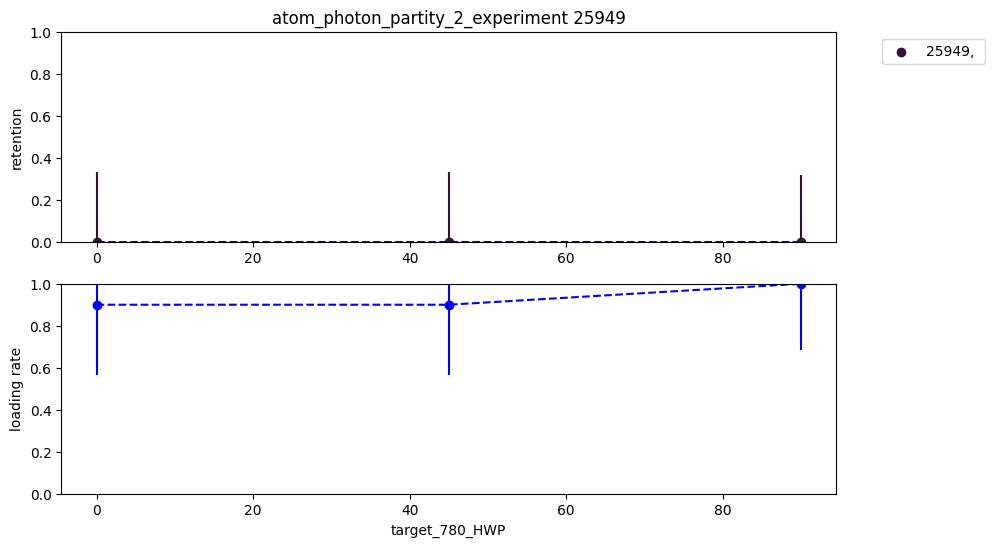

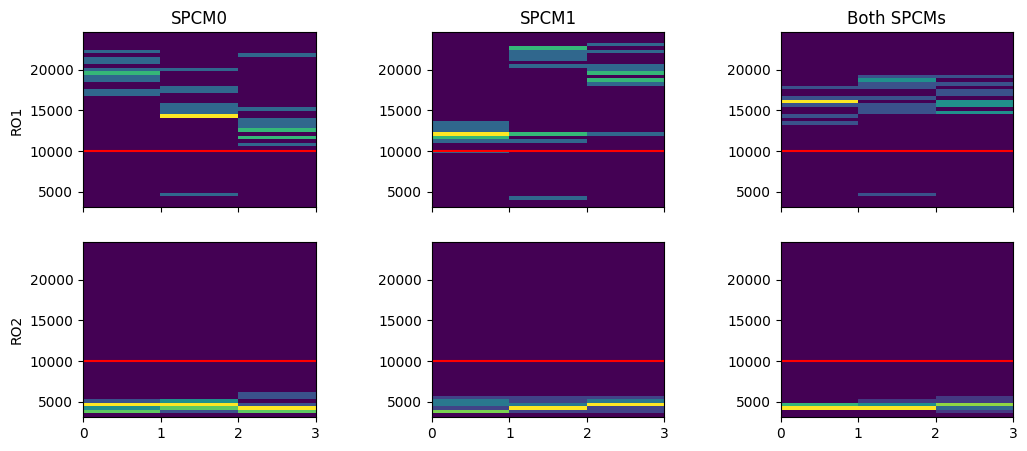

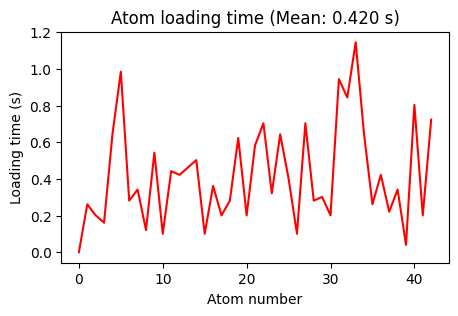

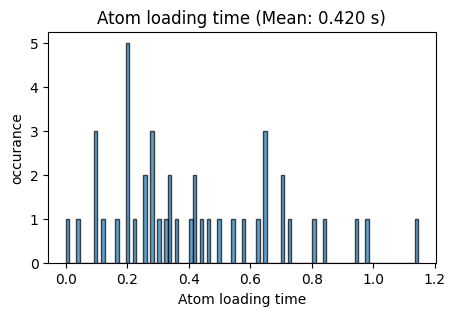

In [166]:
### the file(s) to analyze:
file_indices = {
    65:'',
    # 40:'',
    # 42:'',
    # 44:'',
    # 46:'',
    # 50:'',
    # 51:'',
    # 53:'',
    # 54:'',
    # 56:'',
    # 58:'',
    # 60:'',
    # 62:'',
    # 64:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False, figsize=(10, 6))
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


SPCM0_RO1_hists = []
SPCM0_RO2_hists = []
SPCM1_RO1_hists = []
SPCM1_RO2_hists = []
BothSPCMs_RO1_hists = []
BothSPCMs_RO2_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(BothSPCMs_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot
    if showhist:
        SPCM0_RO1_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM0_RO2_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO2_hists.append(
            [np.histogram(SPCM1_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])
        
        BothSPCMs_RO1_hists.append(
            [np.histogram(BothSPCMs_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        BothSPCMs_RO2_hists.append(
            [np.histogram(BothSPCMs_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=False)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            ### for fitting
            ### Auto-detect rough center from minimum retention
            fit_dict = {}
            min_idx = np.argmin(retention_array)
            initial_center = scan_sequence1[min_idx]
            p0 = [initial_center, 10e3, 0.9] # [center, width, depth]
            
            ### using a  Gaussian function for now:
            fit_dict = {
                scan_variable1_name: {
                    'model': lambda x, center, sigma, depth: 0.80*(1 - depth * np.exp(-((x - center)**2/(2*sigma**2)))),
                    'p0': p0,
                    'bounds': ([min(scan_sequence1), 0, 0], [max(scan_sequence1), np.inf, 1]),
                    'params': ['center', 'sigma', 'depth']
                }
            }

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True)  # 2 rows, 3 columns
    ax, ax2, ax3, ax4, ax5, ax6 = axes.ravel()  # Flatten the 2D axes array for easier unpacking

    ### Plot for SPCM0 RO1 in the 1st row, 1st column
    cax = ax.imshow(np.array(SPCM0_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax.set_ylabel("RO1")
    ax.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax.set_aspect('auto')
    ax.set_title("SPCM0")

    ### Plot for SPCM1 RO1 in the 1st row, 2nd column
    cax2 = ax2.imshow(np.array(SPCM1_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax2.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax2.set_aspect('auto')
    ax2.set_title("SPCM1")

    ### Plot for BothSPCMs RO1 in the 1st row, 3rd column
    cax3 = ax3.imshow(np.array(BothSPCMs_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax3.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax3.set_aspect('auto')
    ax3.set_title("Both SPCMs")

    ### Plot for SPCM0 RO2 in the 2nd row, 1st column
    cax4 = ax4.imshow(np.array(SPCM0_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax4.set_ylabel("RO2")
    ax4.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax4.set_aspect('auto')

    ### Plot for SPCM1 RO2 in the 2nd row, 2nd column
    cax5 = ax5.imshow(np.array(SPCM1_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax5.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax5.set_aspect('auto')

    ### Plot for BothSPCMs RO2 in the 2nd row, 3rd column
    cax6 = ax6.imshow(np.array(BothSPCMs_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax6.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax6.set_aspect('auto')

    plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.show()

#######  Atom loading time plot
## We can slice the array to separate iterations later, if we want.
mean_loading_time = np.mean(Atom_loading_time)  
plt.figure(figsize=(5, 3))
plt.plot(Atom_loading_time, 'r-')

plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(Atom_loading_time, bins=100, edgecolor='black', alpha=0.7)
# plt.plot(Atom_loading_time, 'r-')

plt.xlabel("Atom loading time")
plt.ylabel("occurance")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()

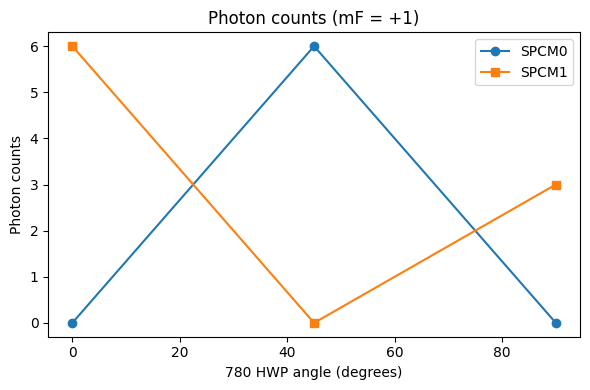

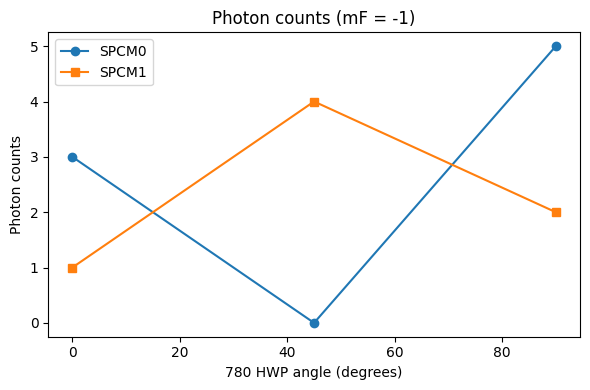

In [167]:
"""
atom_Z1_mask: [True, True, False, ...] is True when the atom is in state mF=+1 (i.e. atom_signal<single_atom_threshold) in Z-basis.
atom_Zm1_mask: [False, False, True, ...] is True when the atom is in state mF=-1 (i.e. atom_signal<single_atom_threshold) in Z-basis.

unique_angles_780_HWP = [0,10,20,...]

angle_780_HWP_Z1_filtered = [0,0,0,10,10,20,...]

"""
### Compute atom state
atom_signal = BothSPCMs_parity_RO[1:] / t_SPCM_second_shot
atom_Z1_mask = atom_signal <= single_atom_threshold
atom_Zm1_mask = ~atom_Z1_mask

### Unify the HWP angles
unique_angles_780_HWP = np.unique(angle_780_HWP)

############### ---- Plot for mF = +1 ----
angle_780_HWP_Z1_filtered = angle_780_HWP[atom_Z1_mask]
SPCM0_Z1_filtered = SPCM0_SinglePhoton[1:][atom_Z1_mask]
SPCM1_Z1_filtered = SPCM1_SinglePhoton[1:][atom_Z1_mask]

SPCM0_counts_Z1_filtered = []
SPCM1_counts_Z1_filtered = []

for angle in unique_angles_780_HWP:
    angle_mask = angle_780_HWP_Z1_filtered == angle
    SPCM0_counts_Z1_filtered.append(np.sum(SPCM0_Z1_filtered[angle_mask]))
    SPCM1_counts_Z1_filtered.append(np.sum(SPCM1_Z1_filtered[angle_mask]))

plt.figure(figsize=(6, 4))
plt.plot(unique_angles_780_HWP, SPCM0_counts_Z1_filtered, label='SPCM0', marker='o')
plt.plot(unique_angles_780_HWP, SPCM1_counts_Z1_filtered, label='SPCM1', marker='s')
plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('Photon counts (mF = +1)')
plt.legend()
plt.tight_layout()
plt.show()

################ ---- Plot for mF = -1 ----
angle_780_HWP_Zm1_filtered = angle_780_HWP[atom_Zm1_mask]
SPCM0_Zm1_filtered = SPCM0_SinglePhoton[1:][atom_Zm1_mask]
SPCM1_Zm1_filtered = SPCM1_SinglePhoton[1:][atom_Zm1_mask]

SPCM0_counts_Zm1_filtered = []
SPCM1_counts_Zm1_filtered = []

for angle in unique_angles_780_HWP:
    angle_mask = angle_780_HWP_Zm1_filtered == angle
    SPCM0_counts_Zm1_filtered.append(np.sum(SPCM0_Zm1_filtered[angle_mask]))
    SPCM1_counts_Zm1_filtered.append(np.sum(SPCM1_Zm1_filtered[angle_mask]))

plt.figure(figsize=(6, 4))
plt.plot(unique_angles_780_HWP, SPCM0_counts_Zm1_filtered, label='SPCM0', marker='o')
plt.plot(unique_angles_780_HWP, SPCM1_counts_Zm1_filtered, label='SPCM1', marker='s')
plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('Photon counts (mF = -1)')
plt.legend()
plt.tight_layout()
plt.show()


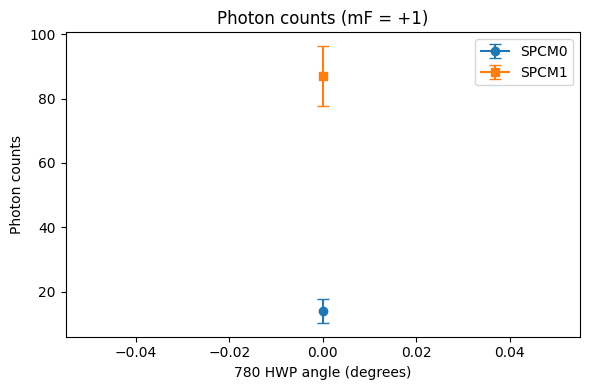

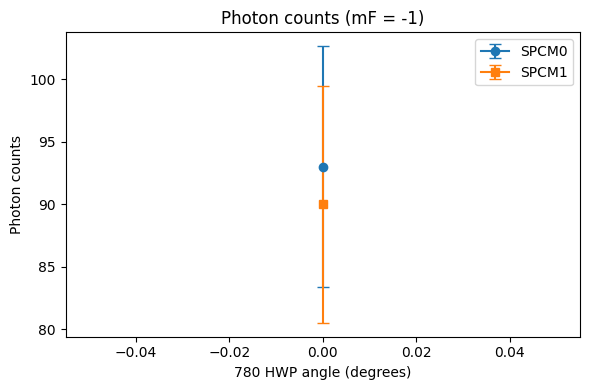

In [163]:

### Compute atom state
atom_signal = BothSPCMs_parity_RO[1:] / t_SPCM_second_shot
atom_Z1_mask = atom_signal <= single_atom_threshold
atom_Zm1_mask = ~atom_Z1_mask

### Unify the HWP angles
unique_angles_780_HWP = np.unique(angle_780_HWP)

###############  Plot for mF = +1
angle_780_HWP_Z1_filtered = angle_780_HWP[atom_Z1_mask]
SPCM0_Z1_filtered = SPCM0_SinglePhoton[1:][atom_Z1_mask]
SPCM1_Z1_filtered = SPCM1_SinglePhoton[1:][atom_Z1_mask]

SPCM0_counts_Z1_filtered = []
SPCM1_counts_Z1_filtered = []
SPCM0_errors_Z1_filtered = []
SPCM1_errors_Z1_filtered = []

for angle in unique_angles_780_HWP:
    angle_mask = angle_780_HWP_Z1_filtered == angle
    count0 = np.sum(SPCM0_Z1_filtered[angle_mask])
    count1 = np.sum(SPCM1_Z1_filtered[angle_mask])
    SPCM0_counts_Z1_filtered.append(count0)
    SPCM1_counts_Z1_filtered.append(count1)
    SPCM0_errors_Z1_filtered.append(np.sqrt(count0))
    SPCM1_errors_Z1_filtered.append(np.sqrt(count1))

plt.figure(figsize=(6, 4))
plt.errorbar(unique_angles_780_HWP, SPCM0_counts_Z1_filtered, yerr=SPCM0_errors_Z1_filtered,
             marker='o', capsize=4, label='SPCM0')
plt.errorbar(unique_angles_780_HWP, SPCM1_counts_Z1_filtered, yerr=SPCM1_errors_Z1_filtered,
             marker='s', capsize=4, label='SPCM1')
plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('Photon counts (mF = +1)')
plt.legend()
plt.tight_layout()
plt.show()

###############  Plot for mF = -1
angle_780_HWP_Zm1_filtered = angle_780_HWP[atom_Zm1_mask]
SPCM0_Zm1_filtered = SPCM0_SinglePhoton[1:][atom_Zm1_mask]
SPCM1_Zm1_filtered = SPCM1_SinglePhoton[1:][atom_Zm1_mask]

SPCM0_counts_Zm1_filtered = []
SPCM1_counts_Zm1_filtered = []
SPCM0_errors_Zm1_filtered = []
SPCM1_errors_Zm1_filtered = []

for angle in unique_angles_780_HWP:
    angle_mask = angle_780_HWP_Zm1_filtered == angle
    count0 = np.sum(SPCM0_Zm1_filtered[angle_mask])
    count1 = np.sum(SPCM1_Zm1_filtered[angle_mask])
    SPCM0_counts_Zm1_filtered.append(count0)
    SPCM1_counts_Zm1_filtered.append(count1)
    SPCM0_errors_Zm1_filtered.append(np.sqrt(count0))
    SPCM1_errors_Zm1_filtered.append(np.sqrt(count1))

plt.figure(figsize=(6, 4))
plt.errorbar(unique_angles_780_HWP, SPCM0_counts_Zm1_filtered, yerr=SPCM0_errors_Zm1_filtered,
             marker='o', capsize=4, label='SPCM0')
plt.errorbar(unique_angles_780_HWP, SPCM1_counts_Zm1_filtered, yerr=SPCM1_errors_Zm1_filtered,
             marker='s', capsize=4, label='SPCM1')
plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('Photon counts (mF = -1)')
plt.legend()
plt.tight_layout()
plt.show()



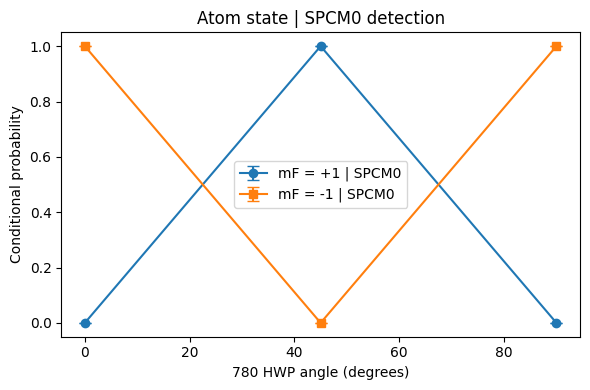

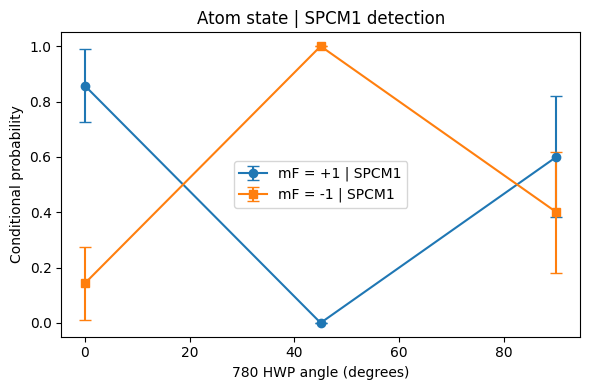

In [168]:
# Compute atom state
atom_signal = BothSPCMs_parity_RO[1:] / t_SPCM_second_shot
atom_mF_plus = atom_signal < single_atom_threshold  # Boolean mask for mF = +1
atom_mF_minus = ~atom_mF_plus                      # Boolean mask for mF = -1

# Detection masks
SPCM0_detected = SPCM0_SinglePhoton[1:] > 0
SPCM1_detected = SPCM1_SinglePhoton[1:] > 0

# Waveplate angles (assumed already sliced to match data)
angles = angle_780_HWP
unique_angles = np.unique(angles)

# Helper function to compute conditional probabilities
def compute_conditional_prob(detection_mask, label):
    prob_mF_plus = []
    err_mF_plus = []
    prob_mF_minus = []
    err_mF_minus = []

    for angle in unique_angles:
        angle_mask = angles == angle
        selected = detection_mask & angle_mask
        total = np.sum(selected)

        if total == 0:
            prob_mF_plus.append(np.nan)
            err_mF_plus.append(np.nan)
            prob_mF_minus.append(np.nan)
            err_mF_minus.append(np.nan)
            continue

        mF_plus_count = np.sum(atom_mF_plus[selected])
        mF_minus_count = np.sum(atom_mF_minus[selected])

        p_plus = mF_plus_count / total
        p_minus = mF_minus_count / total

        err_plus = np.sqrt(p_plus * (1 - p_plus) / total)
        err_minus = np.sqrt(p_minus * (1 - p_minus) / total)

        prob_mF_plus.append(p_plus)
        err_mF_plus.append(err_plus)
        prob_mF_minus.append(p_minus)
        err_mF_minus.append(err_minus)

    return prob_mF_plus, err_mF_plus, prob_mF_minus, err_mF_minus



###################  Plot for SPCM0 detection
pZ1_0, errZ1_0, pZm1_0, errZm1_0 = compute_conditional_prob(SPCM0_detected, "SPCM0")

plt.figure(figsize=(6, 4))
plt.errorbar(unique_angles, pZ1_0, yerr=errZ1_0, marker='o', capsize=4, label='mF = +1 | SPCM0')
plt.errorbar(unique_angles, pZm1_0, yerr=errZm1_0, marker='s', capsize=4, label='mF = -1 | SPCM0')
plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Conditional probability')
plt.title('Atom state | SPCM0 detection')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
plt.show()



##################  Plot for SPCM1 detection 
pZ1_1, errZ1_1, pZm1_1, errZm1_1 = compute_conditional_prob(SPCM1_detected, "SPCM1")

plt.figure(figsize=(6, 4))
plt.errorbar(unique_angles, pZ1_1, yerr=errZ1_1, marker='o', capsize=4, label='mF = +1 | SPCM1')
plt.errorbar(unique_angles, pZm1_1, yerr=errZm1_1, marker='s', capsize=4, label='mF = -1 | SPCM1')
plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Conditional probability')
plt.title('Atom state | SPCM1 detection')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
plt.show()
